## Машинное обучение, ФКН ВШЭ

## Практическое задание 4

### Общая информация
Дата выдачи: 12 октября 2018

Мягкий дедлайн: 7:59MSK 20 октября 2018 (за каждый день просрочки снимается 1 балл)

Жесткий дедлайн: 23:59MSK 21 октября 2018.

### О задании

В этом задании вы:
- настроите метод опорных векторов, визуализируете опорные вектора
- познакомитесь с калибровочными кривыми и сравните вероятности, выдаваемые логистической регрессией и методом опорных векторов
- изучите методы работы с категориальными переменными
- в качестве бонуса попробуете библиотеку vowpal wabbit.


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-Username.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-IvanovIvan.ipynb).

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

** Оценка:** 11.5

In [1]:
%pylab inline
import pandas as pd
import scipy
import random
import time
import scikitplot as skplt

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV 


Populating the interactive namespace from numpy and matplotlib


## Часть 1. Метод опорных векторов и калибровка вероятностней

Сгенерируем синтетические данные.

In [2]:
X, y = make_classification(n_samples=100000, n_features=20,
                                    n_informative=10, n_redundant=10,
                                    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=42)

__Задание 1.__ Обучение и применение метода опорных векторов.

__(2 балла)__

Обучите метод опорных векторов. На занятиях мы проходили обычный вариант, что соответствует линейному ядру (LinearSVC/LinearSVR в scikit-learn).

In [3]:
linear_model = LinearSVC()
linear_model.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

На тестовой части посчитайте ROC-AUC, PR-AUC. Постройте ROC и PR кривые.

In [4]:
print("pr_auc_score:", metrics.roc_auc_score(y_test, linear_model.predict(X_test)))
print("roc_auc_score:", metrics.average_precision_score(y_test, linear_model.predict(X_test)))

pr_auc_score: 0.8502076519993309
roc_auc_score: 0.796268967140193


/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


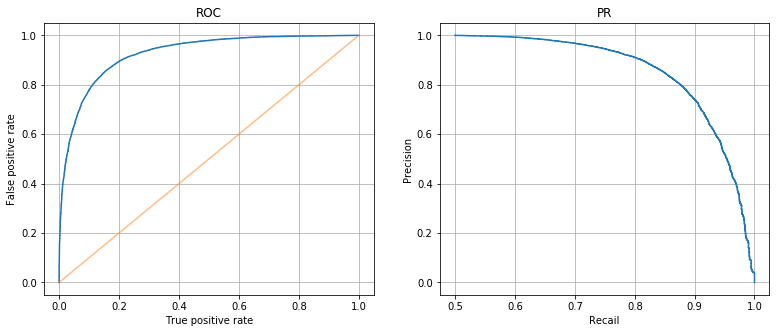

In [5]:
def draw_roc_pr_graphs():
    precision = linear_model.decision_function(X_test)
    roc_false_rate, roc_true_rate, _ = metrics.roc_curve(y_test, precision)
    roc_auc = metrics.auc(roc_false_rate, roc_true_rate)
    precicion_rate, recall_rate, _ = metrics.precision_recall_curve(y_test, precision)


    f, (roc_graph, pr_graph) = plt.subplots(1, 2, figsize=(13, 5))

    roc_graph.plot(roc_false_rate, roc_true_rate)
    roc_graph.set_title(u"ROC")
    roc_graph.set_xlabel(u"True positive rate")
    roc_graph.set_ylabel(u"False positive rate")
    roc_graph.plot([0, 1], [0, 1], alpha=0.5)
    roc_graph.grid()


    pr_graph.plot(precicion_rate, recall_rate)
    pr_graph.set_title(u"PR")
    pr_graph.set_xlabel(u"Recail")
    pr_graph.set_ylabel(u"Precision")
    pr_graph.grid()

    f.show()
    
draw_roc_pr_graphs()

В названии метода присутствуют некоторые "опорные векторы". Сгенерируйте синтетический датасет с помощью make_classification с 2 признаками, обучите на нём метод опорных векторов. Визуализируйте разделяющую прямую, все объекты и выделите опорные вектора (атрибут support\_vectors\_). В этот раз вместо LinearSVC воспользуйтесь SVC с линейным ядром (kernel='linear'), так как только в нём есть информация об опорных векторах.

In [6]:
x_data, y_data = make_classification(n_samples=500, n_redundant=0, n_informative=2, n_classes=2, n_features=2)
svc_model = SVC(kernel='linear')
svc_model.fit(x_data, y_data)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

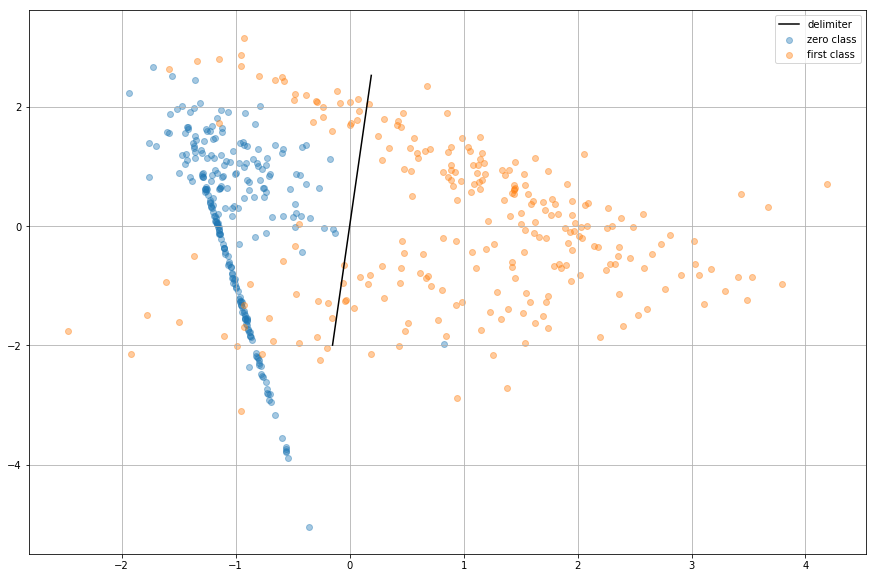

In [7]:
def draw_svc_graph():
    plt.figure(figsize=(15,10))
    plt.grid()
    zero_points = x_data[y_data == 0]
    first_points = x_data[y_data == 1]
    y = (svc_model.coef0 + np.arange(-0.15, 0.2, 0.01) * svc_model.coef_[0][0]) / svc_model.coef_[0][1]
    plt.plot(np.arange(-0.15, 0.2, 0.01), y, color='black', label='delimiter')
    
    plt.scatter(zero_points[:,0], zero_points[:,1], alpha=0.4, label='zero class')
    plt.scatter(first_points[:,0], first_points[:,1], alpha=0.4, label='first class')
    
    plt.legend()
    plt.show()
draw_svc_graph()

__Задание 2.__ Калибровка вероятностей.

__(2 балла)__

Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых. 

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность? Для этого разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины. Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной. Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [8]:
def calibration_curve_points(y_test, predictions):
    predictions = predictions / np.max(predictions)
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 20
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2)
        bin_real_ratios.append(
            np.sum(
                y_test[(predictions >= l) & (predictions < r)] == 1
            ) / np.shape(
                y_test[(predictions >= l) & (predictions < r)]
            )[0]
        )
    return bin_middle_points, bin_real_ratios

Постройте калибровочные кривые для логистической регрессии и метода опорных векторов. Изучите распределение ответов классификаторов (постройте гистограммы с помощью plt.hist). Чем они различаются? Чем вы можете объяснить это?

Заметим, что метод опорных векторов не умеет predict_proba, но имеет метод decision_function.

In [9]:
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


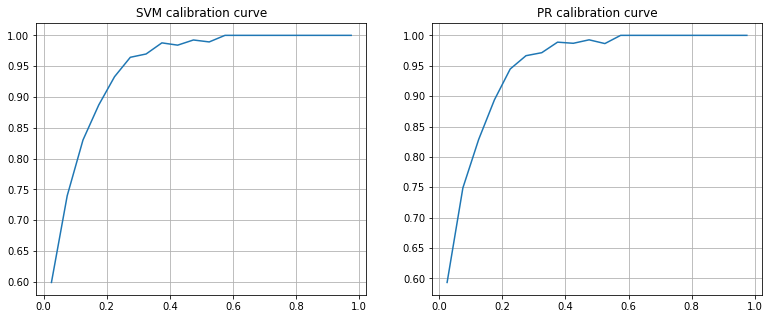

In [10]:
def draw_calibration_curves():
    svm_points = calibration_curve_points(y_test, linear_model.decision_function(X_test))
    lr_points = calibration_curve_points(y_test, lr_model.decision_function(X_test))
    
    f, (svm_graph, lr_graph) = plt.subplots(1, 2, figsize=(13, 5))

    svm_graph.plot(svm_points[0], svm_points[1])
    svm_graph.set_title(u"SVM calibration curve")
    svm_graph.grid()

    lr_graph.plot(lr_points[0], lr_points[1])
    lr_graph.set_title(u"PR calibration curve")
    lr_graph.grid()

    f.show()
draw_calibration_curves()

Воспользуйтесь CalibratedClassifierCV из sklearn для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью предсказания для тестовой выборки. Нарисуйте для них калибровочную кривую. Улучшилась ли она?

In [11]:
cccv_model = CalibratedClassifierCV()
cccv_model.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=None, cv=3, method='sigmoid')

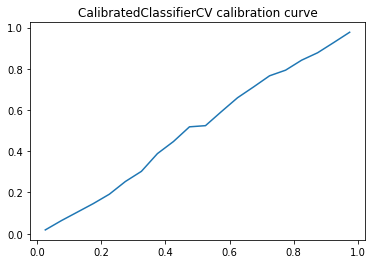

In [12]:
def draw_cccv_calibration_curve():
    points = calibration_curve_points(y_test, cccv_model.predict_proba(X_test)[:,1])
    plt.title('CalibratedClassifierCV calibration curve')
    plt.plot(points[0], points[1])
    plt.show()
draw_cccv_calibration_curve()

Очевидно, что да, предсказание улучишилось, поскольку приблизилось к эталонной прямой.

__Бонусное задание (1 балл).__ Реализуйте свою функцию для калибровки вероятностей. Опишите ваш подход и продемонстрируйте результаты.

before: [0.25006    1.90165601 3.6191737  ... 0.09456087 0.63435729 1.16367857]
predictions: [0.5374388  0.75786202 0.89766123 ... 0.51418033 0.59402127 0.66779015]


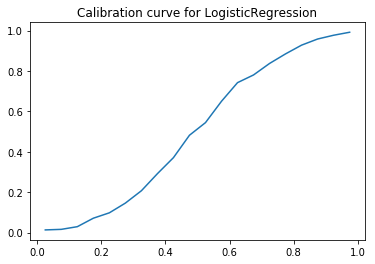

In [13]:
def fermi_dirak(x, a = 0.3):
    return 1 / (e ** (-2 * a * x) + 1)

def calibrate_predictions(predictions):
    print("before:", predictions)
    for i in range(len(predictions)):
        predictions[i] = fermi_dirak(predictions[i])
    print("predictions:", predictions)
    return predictions

def draw_my_calibration_of_lr():
    predictions = lr_model.decision_function(X_test)
    points = calibration_curve_points(y_test, calibrate_predictions(predictions))
    plt.title('Calibration curve for LogisticRegression')
    plt.plot(points[0], points[1])
    plt.show()
draw_my_calibration_of_lr()

В качестве калибрующей функции была выбрана Функция Ферми — Дирака с параметром $a = 0.3$. Как мы видим, это дало некоторые положительные результаты.

## Часть 2. Работа с категориальными переменными

В этой части мы научимся обрабатывать категориальные переменные, так как закодировать их в виде чисел недостаточно (это задаёт некоторый порядок, которого на категориальных переменных может и не быть). Существует два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

__Подготовка данных.__

Загрузим данные с прошлогоднего конкурса  [Kaggle Porto Seguro’s Safe Driver Prediction](https://www.kaggle.com/c/porto-seguro-safe-driver-prediction) (вам нужна только обучающая выборка). Задача состоит в определении водителей, которые в ближайший год воспользуются своей автомобильной страховкой (бинарная классификация). Но для нас важна будет не сама задача, а только её данные. При этом под нужды задания мы немного модифицируем датасет.

In [46]:
data = pd.read_csv('train.csv', index_col=0)
target = data.target.values
data = data.drop('target', axis=1)

Пересемплируем выборку так, чтобы положительных и отрицательных объектов в выборке было одинаковое число. Разделим на обучающую и тестовую выборки.


In [15]:
# some resampling
np.random.seed(910)
mask_plus = np.random.choice(np.where(target == 1)[0], 100000, replace=True)
mask_zero = np.random.choice(np.where(target == 0)[0], 100000, replace=True)

data = pd.concat((data.iloc[mask_plus], data.iloc[mask_zero]))
target = np.hstack((target[mask_plus], target[mask_zero]))

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.5)

__Задание 0.__ Посчитайте качество (в этом задании будем работать ROC-AUC) на исходных признаках при применении логистической регрессии.

__(0 баллов)__

In [23]:
lr_model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [24]:
print("roc auc score:", metrics.roc_auc_score(y_test, lr_model.decision_function(X_test) / np.max(lr_model.decision_function(X_test))))

roc auc score: 0.6250609338008775


__Задание 1.__ Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (с тем, что было до кодирования). Измерьте время, потребовавшееся на обучение модели.

__(1 балл)__

In [44]:
def one_hot(data):
    for column in data.columns:
        if column.find('_cat') != -1:
            dummy = pd.get_dummies(data[column])
            data.drop([column], axis=1)
            data = pd.concat([data, dummy], axis=1)
    return data

def calculate_quality():
    start = time.time()
    lr_model.fit(X_train, y_train)
    print("model train time: ", time.time() - start)
    prediction = lr_model.decision_function(X_test)
    print("roc auc score:", metrics.roc_auc_score(y_test, prediction / np.max(prediction)))

X_train, X_test, y_train, y_test = train_test_split(one_hot(data), target, test_size=0.5)
calculate_quality()

model train time:  22.93218493461609
roc auc score: 0.6350630957928615


Как можно было заменить, one-hot-кодирование может сильно увеличивать количество признаков в датасете, что сказывается на памяти, особенно, если некоторый признак имеет большое количество значений. Эту проблему решает другой способ кодирование категориальных признаков — счётчики. Основная идея в том, что нам важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:
$$
g_j(x, X) = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)]}
$$

__Задание 2.__ Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве. Сравните время обучения с предыдущим экспериментов. Заметили ли вы что-то интересное?

__(2 балла)__

In [59]:
def counters_code(data, add_noize):
    for column in data.columns:
        if column.find('_cat') != -1:
            group = data.groupby(column).mean()
            dictionary = dict()
            for i in range(len(group.index)):
                dictionary[group.index[i]] = group['target'][group.index[i]]
            data[column] = data[column].apply(lambda x: dictionary[x]) + random.random() * add_noize
    
    data = data.drop('target', axis=1)
    return data
data = pd.read_csv('train.csv', index_col=0)
target = data.target.values
X_train, X_test, y_train, y_test = train_test_split(counters_code(data, 0), target, test_size=0.5)
calculate_quality()

model train time:  28.27519726753235
roc auc score: 0.6211533267874733


Отметим, что такие признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к переобучению, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его целевая метка не использовалась. Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки. 

__Задание 3.__ Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям (необходимо соблюсти баланс между избавление от переобучения и полезностью признаков). Снова обучите логистическую регрессию, оцените качество. Сделайте выводы.

__(1 балл)__

__(Бонусная часть)__ Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум). 

__(+0.5 балла)__

In [60]:
data = pd.read_csv('train.csv', index_col=0)
target = data.target.values
X_train, X_test, y_train, y_test = train_test_split(counters_code(data, 1), target, test_size=0.5)
calculate_quality()

model train time:  35.54041504859924
roc auc score: 0.37455915238113235


Вывод: добавление шума довольно сильно ухудшает результат, следовательно метод склонен к переобучению.

А теперь ответьте на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — среднее значение целевой переменной по всей выборке, $C$ — параметр, определяющий степень сглаживания (например, можно использовать 10 или подобрать для каждого признака свой). Основная идея в том, что мы "разбавляем" среднее значение по некоторой категории глобальным средним значении. И тем меньше, чем большее количество объектов этой категории встречается в выборке. 

Однако для сглаживания вместо среднего значения целевой переменной можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

__Задание 4.__ Добавьте сглаживание, описанное выше и повторите эксперименты.

__(2 балла)__

In [68]:
def smoothing(data, target):
    data['target'] = target
    for column in data.columns:
        if column.find('_cat') != -1:
            group = data.groupby(column).mean()
            dictionary = dict()
            for i in range(len(group.index)):
                dictionary[group.index[i]] = group['target'][group.index[i]]
            data[column] = data[column].apply(lambda x: dictionary[x] / (dictionary[x] + 12))
    
    data = data.drop('target', axis=1)
    return data
data = pd.read_csv('train.csv', index_col=0)
target = data.target.values
X_train, X_test, y_train, y_test = train_test_split(smoothing(counters_code(data, 0), target), target, test_size=0.5)
calculate_quality()    

model train time:  13.202814102172852
roc auc score: 0.3921414258794117


__Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).

Как вы должны были заметить, счётчики являются хорошей альтернативой one-hot-кодированию. Напишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием, вы заметили.

__Ответ:__ главный плюс в том, что отсутствует добавление большого множества новых фичей, по одному на каждое состояние исходной.

**Задание 5.** Какой лучший мем в 2k18?

__Ответ:__ ...


**Задание 6.** Поделитесь лучшим стикерпаком. Только там не должно быть преподавателей и ассистентов этого курса.

__Ответ:__ https://t.me/addstickers/tom_of_finland

## Часть 3 (бонус). Vowpal Wabbit

В этой части мы научимся использовать библиотеку [vowpal wabbit](https://github.com/JohnLangford/vowpal_wabbit). У неё есть несколько особенностей:
- можно обучать только линейные модели, но за счёт большого количества опций и возможностей по усложнению, можно построить и довольно сложные вещи
- можно обучаться на выборках, которые не помещаются в оперативную память
- можно обрабатывать большое количество признаков (например, мешки слов текстов) и "на ходу" строить на них комбинации (не переделывать датасет)
- другие особенности, как например, активное обучение и возможность распараллеленного обучения.

Основные особенности при использовании следующие:
- Свой формат данных: "label |A feature1:value1 |B feature2:value2", позволяющий, во-первых, указывать не все признаки (не нужно хранить много нулей в разреженных данных), а во-вторых, группировать и иметь возможность отключать или взаимодействовать ("отключать", добавлять квадратичные признаки и т.д.) сразу со всей группой признаков. По этой причине вам понадобится реализовать конвертер датасета и загрузку своих предсказаний, чтобы посчитать качество предсказаний.
- Запуск обучения из командной строки (однако можно запускать эти же команды из ноутбука).

В этот раз мы будем использовать данные с конкурса [Kaggle Avazu Click-Through Rate Prediction](https://www.kaggle.com/c/avazu-ctr-prediction) по предсказанию кликов (бинарная классификация). В обучающей выборке 40kk строк, так что у вас не должно быть желания загружать их в оперативную память. Предлагается взять первые 30kk строк в качестве обучающей выборке и оставшуюся часть для тестирования.

__Задание 1.__ Работа с vowpal wabbit. 

- Скачайте данные, разделите их на обучающую и тестовую выборки.
- Подготовьте функции для конвертирования датасета в формат vowpal wabbit и для загрузки предсказаний в ноутбук для подсчёта функционала.
- Сделайте простейшее решение на vowpal wabbit. Оцените качество.
- Изучите возможности и параметры vowpal wabbit. Поэксперементируйте. 
- Расскажите, что интересного вы узнали (какие-нибудь особенности, режимы работы, фишки, параметры).
- Удалось ли вам улучшить качество базовой модели? Насколько? Что ещё можно было бы попробовать?

В этом задании предусмотрены баллы по двум критериям:
- достижение ROC-AUC на отложенной выборки более 0.738 __(1 балл)__
- несколько занимательных фактов и возможностей vowpal-wabbit __(0.5 балла)__.

In [22]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ